## 检测python版本
这里我们使用的python的版本为3.6.5

In [31]:
import sys
sys.version

'3.6.4 |Anaconda, Inc.| (default, Jan 16 2018, 18:10:19) \n[GCC 7.2.0]'

## 数据预处理
为了更好的训练模型，这里对数据进行一定程度对预处理
- 删除训练数据集中过大（`500*500`以上）和过小（`100*100`以下）的图片。
- 将图片按照一定的目录结构归类。
- 删除错误标记的图片。

In [32]:
import os, shutil
from PIL import Image

# 删除被错误标记的图片
def pick_err_flag(path, bad_path):
    bad_list = ['cat.92.jpg',    'cat.724.jpg',   'cat.1450.jpg',  'cat.3216.jpg', 'cat.3822.jpg', 'cat.5351.jpg',
                'cat.5418.jpg',  'cat.7377.jpg',  'cat.7564.jpg',  'cat.8456.jpg', 'cat.9171.jpg', 'cat.10029.jpg',
                'cat.10712.jpg', 'cat.11184.jpg', 'dog.1259.jpg',  'dog.1835.jpg', 'dog.2614.jpg', 'dog.3889.jpg',
                'dog.4367.jpg',  'dog.5604.jpg',  'dog.8736.jpg',  'dog.8898.jpg', 'dog.9517.jpg', 'dog.10161.jpg',
                'dog.10190.jpg', 'dog.10237.jpg', 'dog.10401.jpg', 'dog.10797.jpg','dog.10801.jpg','dog.11186.jpg',
                'dog.11299.jpg', 'dog.12376.jpg', 'dog.10747.jpg']
    for img_name in bad_list:
        im_path = os.path.join(path, img_name)
        if os.path.exists(im_path):
            shutil.move(im_path, os.path.join(bad_path, img_name))
    print(len(bad_list))

pick_err_flag("data/train", "data/train_bad")

33


In [33]:
# 删除不合尺寸
def pick_bad_pics(path, bad_path):
    bad_list = []
    img_list = os.listdir(path)
    for img_name in img_list:
        im_path = os.path.join(path, img_name)
        im = Image.open(im_path)
        w, h = im.size
        if w > 500 or h > 500 or w < 10 or h < 10:
            bad_list.append(img_name)
            shutil.move(im_path, os.path.join(bad_path, img_name))
    print(len(bad_list))

pick_bad_pics("data/train", "data/train_bad")

2


## 读取加载数据集，归一化处理
将用于训练的数据集加载到内存，等待处理。主要是转化为ndarray类型到数据，方便后续到计算和处理.因为选择到预训练模型，对于图片到要求都是`299*299`大小，这里我们读取数据时，图片统一调整到这个尺寸。
- 加载训练集数据。
- 加载测试集数据。
- 输出一个经过正规化的、Numpy array 格式的图像数据。

In [34]:
import glob, cv2
import numpy as np
from tqdm import tqdm

# 加载训练集
def load_train_data():

    cat = glob.glob("data/train/cat.*.jpg")
    dog = glob.glob("data/train/dog.*.jpg")
    train_data = np.zeros(((len(cat)+len(dog)), 299, 299, 3), dtype=np.uint8)
    train_targ = np.array([0]*len(cat) + [1]*len(dog))

    i = 0
    for img_name in tqdm(cat):
        img = cv2.imread(img_name)
        train_data[i] = cv2.resize(img,(299, 299))
        i += 1
    for img_name in tqdm(dog):
        img = cv2.imread(img_name)
        train_data[i] = cv2.resize(img,(299, 299))
        i += 1

    return train_data, train_targ

# 加载测试集
def load_test_data():

    test = glob.glob("data/test/*.jpg")
    test_data = np.zeros((len(test), 299, 299, 3), dtype=np.uint8)
    
    i = 0
    for img_name in tqdm(test):
        img = cv2.imread(img_name)
        test_data[i] = cv2.resize(img,(299, 299))
        i += 1
    
    return test_data

In [35]:
# 处理，加载训练集数据
train_data, train_targ = load_train_data()

100%|██████████| 12480/12480 [00:40<00:00, 310.59it/s]


In [36]:
# 处理，加载测试集数据
test_data = load_test_data()

100%|██████████| 12500/12500 [00:39<00:00, 314.64it/s]


In [37]:
print(train_data.shape, train_targ.shape, test_data.shape)

(24965, 299, 299, 3) (24965,) (12500, 299, 299, 3)


## 拆分验证集
对标记数据进行处理，拆分验证集

In [38]:
from sklearn.model_selection import train_test_split

# 划分数据
x_train, x_valid, y_train, y_valid = train_test_split(train_data, train_targ, test_size=0.2)

## 模型InceptionV3
预训练模型InceptionV3

In [39]:
import keras
import pandas as pd

In [9]:
# 构建InceptionV3
def buid_inceptionv3():

    # 获取基础模型，不保留顶层的全连接网络
    input_tensor = keras.Input(shape=(299, 299, 3)) 
    input_tensor = keras.layers.Lambda(keras.applications.inception_v3.preprocess_input)(input_tensor)
    base_model   = keras.applications.inception_v3.InceptionV3(input_tensor=input_tensor, include_top=False)

    # 锁定模型，保护处理
    for layer in base_model.layers:
        layer.trainable = False

    # 空域信号施加全局平均池化，dropout处理防止过拟合，重建全连接层
    x = keras.layers.GlobalAveragePooling2D()(base_model.output)
    x = keras.layers.Dropout(0.4)(x)
    x = keras.layers.Dense(1, activation='sigmoid')(x)

    # 配置模型
    result = keras.models.Model(inputs=base_model.input, outputs=x)
    result.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['accuracy'])

    # 返回
    print('InceptionV3 has %d layers.' % len(result.layers))
    return result

# 创建
inceptionv3_obj = buid_inceptionv3()

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


87916544/87910968 [==============================] - 14s 0us/step
InceptionV3 has 315 layers.


In [9]:
# 可视化模型
#keras.utils.plot_model(inceptionv3_obj, to_file='model_inceptionv3.png')
#from IPython.display import SVG
#from keras.utils.vis_utils import model_to_dot
#SVG(model_to_dot(inceptionv3_obj).create(prog='dot', format='svg'))

In [10]:
# 训练
inceptionv3_obj.fit(x_train, y_train, batch_size=64, epochs=10, validation_data=(x_valid, y_valid))

Train on 19813 samples, validate on 4954 samples
Epoch 1/10
19813/19813 [==============================] - 286s 14ms/step - loss: 0.2033 - acc: 0.9290 - val_loss: 0.0484 - val_acc: 0.9903
Epoch 2/10
19813/19813 [==============================] - 277s 14ms/step - loss: 0.1057 - acc: 0.9628 - val_loss: 0.0658 - val_acc: 0.9794
Epoch 3/10
19813/19813 [==============================] - 277s 14ms/step - loss: 0.0910 - acc: 0.9664 - val_loss: 0.1326 - val_acc: 0.9532
Epoch 4/10
19813/19813 [==============================] - 277s 14ms/step - loss: 0.0876 - acc: 0.9680 - val_loss: 0.0704 - val_acc: 0.9782
Epoch 5/10
19813/19813 [==============================] - 277s 14ms/step - loss: 0.0853 - acc: 0.9669 - val_loss: 0.0593 - val_acc: 0.9820
Epoch 6/10
19813/19813 [==============================] - 277s 14ms/step - loss: 0.0852 - acc: 0.9684 - val_loss: 0.0975 - val_acc: 0.9671
Epoch 7/10
19813/19813 [==============================] - 277s 14ms/step - loss: 0.0822 - acc: 0.9686 - val_loss: 0.1

In [11]:
# 预测输出
inceptionv3_predict = inceptionv3_obj.predict(test_data)
inceptionv3_predict = inceptionv3_predict.clip(min=0.005, max=0.995)
inceptionv3_predict = inceptionv3_predict.flatten(order = 'F')

# 保存结果
submission = pd.DataFrame(data = {'id':(np.arange(len(test_data))+1), 'label': inceptionv3_predict})
submission.to_csv('inceptionv3_submission.csv',index=False)

## 模型Xception
预训练模型Xception

In [10]:
# 构建xception
def buid_xception():

    # 获取基础模型，不保留顶层的全连接网络
    input_tensor = keras.Input(shape=(299, 299, 3)) 
    input_tensor = keras.layers.Lambda(keras.applications.xception.preprocess_input)(input_tensor)
    base_model   = keras.applications.xception.Xception(input_tensor=input_tensor, include_top=False)

    # 锁定模型，保护处理
    for layer in base_model.layers:
        layer.trainable = False

    # 空域信号施加全局平均池化，dropout处理防止过拟合，重建全连接层
    x = keras.layers.GlobalAveragePooling2D()(base_model.output)
    x = keras.layers.Dropout(0.4)(x)
    x = keras.layers.Dense(1, activation='sigmoid', kernel_initializer='he_normal')(x)

    # 配置模型
    result = keras.models.Model(inputs=base_model.input, outputs=x)
    result.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['accuracy'])

    # 返回
    print('xception has %d layers.' % len(result.layers))
    return result

# 创建模型
xception_obj = buid_xception()

83689472/83683744 [==============================] - 16s 0us/step
xception has 136 layers.


In [13]:
# 可视化模型
#keras.utils.plot_model(xception_obj, to_file='model_xception.png')
#SVG(model_to_dot(xception_obj).create(prog='dot', format='svg'))

In [14]:
# 训练
xception_obj.fit(x_train, y_train, batch_size=64, epochs=10, validation_data=(x_valid, y_valid))

Train on 19813 samples, validate on 4954 samples
Epoch 1/10
19813/19813 [==============================] - 498s 25ms/step - loss: 0.1458 - acc: 0.9641 - val_loss: 0.0931 - val_acc: 0.9782
Epoch 2/10
19813/19813 [==============================] - 493s 25ms/step - loss: 0.0571 - acc: 0.9841 - val_loss: 0.0632 - val_acc: 0.9826
Epoch 3/10
19813/19813 [==============================] - 493s 25ms/step - loss: 0.0491 - acc: 0.9843 - val_loss: 0.0631 - val_acc: 0.9822
Epoch 4/10
19813/19813 [==============================] - 493s 25ms/step - loss: 0.0440 - acc: 0.9858 - val_loss: 0.0569 - val_acc: 0.9832
Epoch 5/10
19813/19813 [==============================] - 492s 25ms/step - loss: 0.0417 - acc: 0.9853 - val_loss: 0.0664 - val_acc: 0.9792
Epoch 6/10
19813/19813 [==============================] - 492s 25ms/step - loss: 0.0405 - acc: 0.9856 - val_loss: 0.0786 - val_acc: 0.9754
Epoch 7/10
19813/19813 [==============================] - 492s 25ms/step - loss: 0.0394 - acc: 0.9858 - val_loss: 0.0

In [15]:
# 预测输出
xception_predict = xception_obj.predict(test_data)
xception_predict = xception_predict.clip(min=0.005, max=0.995)
xception_predict = xception_predict.flatten(order = 'F')

# 保存结果
submission = pd.DataFrame(data = {'id':(np.arange(len(test_data))+1), 'label': xception_predict})
submission.to_csv('xception_submission.csv',index=False)

## 模型Inception ResnetV2
预训练模型Inception ResnetV2

In [11]:
# 构建Inception ResnetV2
def buid_inception_resnet_v2():

    # 获取基础模型，不保留顶层的全连接网络
    input_tensor = keras.Input(shape=(299, 299, 3)) 
    input_tensor = keras.layers.Lambda(keras.applications.inception_resnet_v2.preprocess_input)(input_tensor)
    base_model = keras.applications.inception_resnet_v2.InceptionResNetV2(input_tensor=input_tensor, include_top=False)

    # 锁定模型，保护处理
    for layer in base_model.layers:
        layer.trainable = False

    # 空域信号施加全局平均池化，dropout处理防止过拟合，重建全连接层
    x = keras.layers.GlobalAveragePooling2D()(base_model.output)
    x = keras.layers.Dropout(0.4)(x)
    x = keras.layers.Dense(1, activation='sigmoid', kernel_initializer='he_normal')(x)

    # 配置模型
    result = keras.models.Model(inputs=base_model.input, outputs=x)
    result.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['accuracy'])

    # 返回
    print('Inception ResnetV2 has %d layers.' % len(result.layers))
    return result

# 创建
inception_resnet_v2_obj = buid_inception_resnet_v2()

219062272/219055592 [==============================] - 37s 0us/step
Inception ResnetV2 has 784 layers.


In [17]:
# 可视化模型
#keras.utils.plot_model(inception_resnet_v2_obj, to_file='model_inception_resnet_v2.png')
#SVG(model_to_dot(inception_resnet_v2_obj).create(prog='dot', format='svg'))

In [12]:
# 训练
inception_resnet_v2_obj.fit(x_train, y_train, batch_size=64, epochs=10, validation_data=(x_valid, y_valid))

Train on 19813 samples, validate on 4954 samples
Epoch 1/10
19813/19813 [==============================] - 712s 36ms/step - loss: 0.1755 - acc: 0.9453 - val_loss: 0.1235 - val_acc: 0.9578
Epoch 2/10
19813/19813 [==============================] - 654s 33ms/step - loss: 0.0862 - acc: 0.9722 - val_loss: 0.0627 - val_acc: 0.9806
Epoch 3/10
19813/19813 [==============================] - 654s 33ms/step - loss: 0.0749 - acc: 0.9738 - val_loss: 0.0867 - val_acc: 0.9727
Epoch 4/10
19813/19813 [==============================] - 655s 33ms/step - loss: 0.0685 - acc: 0.9753 - val_loss: 0.0595 - val_acc: 0.9836
Epoch 5/10
19813/19813 [==============================] - 655s 33ms/step - loss: 0.0635 - acc: 0.9770 - val_loss: 0.0548 - val_acc: 0.9855
Epoch 6/10
19813/19813 [==============================] - 655s 33ms/step - loss: 0.0607 - acc: 0.9768 - val_loss: 0.0620 - val_acc: 0.9839
Epoch 7/10
19813/19813 [==============================] - 656s 33ms/step - loss: 0.0624 - acc: 0.9771 - val_loss: 0.0

In [13]:
# 预测输出
inception_resnet_v2_predict = inception_resnet_v2_obj.predict(test_data)
inception_resnet_v2_predict = inception_resnet_v2_predict.clip(min=0.005, max=0.995)
inception_resnet_v2_predict = inception_resnet_v2_predict.flatten(order = 'F')

# 保存结果
submission = pd.DataFrame(data = {'id':(np.arange(len(test_data))+1), 'label': inception_resnet_v2_predict})
submission.to_csv('inception_resnet_v2_submission.csv',index=False)

## 提取特征，融合模型
将多个模型到特征向量融合训练

In [40]:
import h5py

# 提取模型的特征数据
def pick_features(raw_model, pre_input):

    # 获取基础模型，不保留顶层的全连接网络
    inputs       = keras.Input(shape=(299, 299, 3))
    input_tensor = keras.layers.Lambda(pre_input)(inputs)
    base_model   = raw_model(input_tensor=input_tensor, include_top=False)

    # 提取特征数据
    x     = keras.layers.GlobalAveragePooling2D()(base_model.output)
    model = keras.models.Model(inputs=inputs, outputs=x)

    train_feature = model.predict(x_train, batch_size=64)
    test_feature  = model.predict(test_data, batch_size=64)

    # 返回
    with h5py.File("feature_%s.h5" % raw_model.__name__, 'w') as f:
        f.create_dataset('train', data=train_feature)
        f.create_dataset('test',  data=test_feature)
        f.create_dataset('label', data=y_train)
    #return train_feature, test_feature

In [41]:
# 获取inceptionv3特征数据
pick_features(keras.applications.inception_v3.InceptionV3, keras.applications.inception_v3.preprocess_input)

In [42]:
# 获取xception特征数据
pick_features(keras.applications.xception.Xception, keras.applications.xception.preprocess_input)

In [43]:
# 获取inception_resnet_v2特征数据
pick_features(keras.applications.inception_resnet_v2.InceptionResNetV2, keras.applications.inception_resnet_v2.preprocess_input)

## 构建模型
构建最终的模型，用特征数据进行训练

In [44]:
train, test= [], []
for fetchfile in ['feature_Xception.h5', 'feature_InceptionV3.h5', 'feature_InceptionResNetV2.h5']:
    with h5py.File(fetchfile, 'r') as h:
        train.append(np.array(h['train']))
        test.append(np.array(h['test']))
        label = np.array(h['label'])
        
train_data_feature = np.concatenate(train, axis=1)
test_data_feature  = np.concatenate(test, axis=1)

In [45]:
x_ft_train, x_ft_valid, y_ft_train, y_ft_valid = train_test_split(train_data_feature, y_train, test_size=0.2)

In [46]:
# 构建融合模型
def buid_final_model():

    inputs = keras.Input(shape=(x_ft_train.shape[1],))
    x = keras.layers.Dropout(0.4)(inputs)
    x = keras.layers.Dense(1, activation='sigmoid', kernel_initializer='he_normal')(x)

    # 配置模型
    final_model = keras.models.Model(inputs=inputs, outputs=x)
    final_model.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['accuracy'])

    # 返回
    return final_model


# 最终模型
final_model_obj = buid_final_model()

## 可视化展示
展示构建的最终模型结构

In [47]:
# 可视化模型
#keras.utils.plot_model(final_model_obj, to_file='model.png')

#from IPython.display import SVG
#from keras.utils.vis_utils import model_to_dot
#SVG(model_to_dot(final_model_obj).create(prog='dot', format='svg'))

In [48]:
import os

# 训练最终模型
def train_final_model(final_model):

    # 模型保存位置
    logs_file = 'ft_extract_features-{val_loss:.4f}.h5'
    path = os.getcwd()
    path_logs = os.path.join(path, logs_file)

    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
    model_check = keras.callbacks.ModelCheckpoint(path_logs, monitor='val_loss', save_best_only=True)

    final_model.fit(x_ft_train, y_ft_train, batch_size=64, epochs=10, 
               validation_data=(x_ft_valid, y_ft_valid), callbacks=[early_stop, model_check])

# 训练
train_final_model(final_model_obj)

Train on 15977 samples, validate on 3995 samples
Epoch 1/10
15977/15977 [==============================] - 20s 1ms/step - loss: 0.0466 - acc: 0.9886 - val_loss: 0.0179 - val_acc: 0.9955
Epoch 2/10
15977/15977 [==============================] - 2s 116us/step - loss: 0.0170 - acc: 0.9954 - val_loss: 0.0133 - val_acc: 0.9942
Epoch 3/10
15977/15977 [==============================] - 2s 115us/step - loss: 0.0144 - acc: 0.9957 - val_loss: 0.0129 - val_acc: 0.9952
Epoch 4/10
15977/15977 [==============================] - 2s 117us/step - loss: 0.0135 - acc: 0.9959 - val_loss: 0.0136 - val_acc: 0.9945
Epoch 5/10
15977/15977 [==============================] - 2s 118us/step - loss: 0.0123 - acc: 0.9971 - val_loss: 0.0126 - val_acc: 0.9952
Epoch 6/10
15977/15977 [==============================] - 2s 115us/step - loss: 0.0118 - acc: 0.9969 - val_loss: 0.0140 - val_acc: 0.9947
Epoch 7/10
15977/15977 [==============================] - 2s 117us/step - loss: 0.0108 - acc: 0.9975 - val_loss: 0.0127 - va

In [49]:
# 预测输出
final_predict = final_model_obj.predict(test_data_feature)
final_predict = final_predict.clip(min=0.005, max=0.995)
final_predict = final_predict.flatten(order = 'F')

# 保存结果
submission = pd.DataFrame(data = {'id':(np.arange(len(test_data))+1), 'label': final_predict})
submission.to_csv('final_submission.csv',index=False)

## 对数损失曲线
绘制模型的对数损失曲线，直观展示

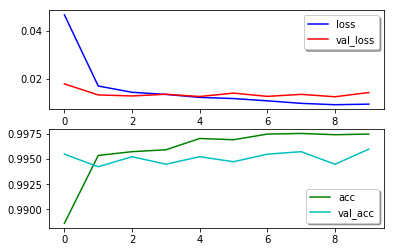

In [50]:
import matplotlib.pyplot as plt

# 对数损失更新曲线
def show_loss(final_model):
    fig, ax = plt.subplots(2,1)
    his_model = final_model.history
    history = his_model.history
    ax[0].plot(history['loss'], color='b', label="loss")
    ax[0].plot(history['val_loss'], color='r', label="val_loss",axes =ax[0])
    legend = ax[0].legend(loc='best', shadow=True)

    ax[1].plot(history['acc'], color='g', label="acc")
    ax[1].plot(history['val_acc'], color='c',label="val_acc")
    legend = ax[1].legend(loc='best', shadow=True)

# 绘制
show_loss(final_model_obj)